A random forest regression model is built to predict the heat capacity ($C_p$) of solid inorganic materials at different temperatures. The dataset is collected from the [NIST JANAF Thermochemical Table](https://doi.org/10.18434/T42S31) 

This project is adapted from recent publication looking at best practices for setting up mateial informatics task.
* [A. Y. T. Wang et al., “Machine Learning for Materials Scientists: An Introductory Guide toward Best Practices,” Chem. Mater., vol. 32, no. 12, pp. 4954–4965, 2020](https://doi.org/10.1021/acs.chemmater.0c01907).

In [1]:
import os 
import pandas as pd 
import numpy as np 

np.random.seed(42)

In [2]:
#----- PLOTTING PARAMS ----# 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# High DPI rendering for mac
%config InlineBackend.figure_format = 'retina'

# Plot matplotlib plots with white background: 
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

plot_params = {
'font.size' : 15,
'axes.titlesize' : 15,
'axes.labelsize' : 15,
'axes.labelweight' : 'bold',
'xtick.labelsize' : 12,
'ytick.labelsize' : 12,
}
 
plt.rcParams.update(plot_params)

# Loading and cleaning the data

In [3]:
root_dir = os.getcwd()
csv_file_path = os.path.join(root_dir, 'material_cp.csv')

df = pd.read_csv(csv_file_path)

In [4]:
df.sample(5)

,FORMULA,CONDITION: Temperature (K),PROPERTY: Heat Capacity (J/mol K)
1207,F2Hg1,1000.0,89.538
3910,Na2O2,400.0,97.721
1183,Fe0.877S1,298.0,49.883
100,B2Mg1,298.0,47.823
3879,N5P3,1000.0,265.266


In [5]:
print(df.shape)

(4583, 3)


In [6]:
df.describe().round(2)

,CONDITION: Temperature (K),PROPERTY: Heat Capacity (J/mol K)
count,4579.00,4576.00
mean,1170.92,107.48
std,741.25,67.02
min,-2000.00,-102.22
25%,600.00,61.31
50%,1000.00,89.50
75%,1600.00,135.65
max,4700.00,494.97


Rename columns for better data handling 

In [7]:
rename_dict = {'FORMULA':'formula', 'CONDITION: Temperature (K)':'T', 'PROPERTY: Heat Capacity (J/mol K)':'Cp'}
df = df.rename(columns=rename_dict)

In [8]:
df

,formula,T,Cp
0,B2O3,1400.0,134.306
1,B2O3,1300.0,131.294
2,B2O3,1200.0,128.072
3,B2O3,1100.0,124.516
4,B2O3,1000.0,120.625
...,...,...,...
4578,Zr1,450.0,26.246
4579,Zr1,400.0,25.935
4580,Zr1,350.0,25.606
4581,Zr1,300.0,NaN


Check for null entries in the dataset

In [9]:
columns_has_NaN = df.columns[df.isnull().any()]
df[columns_has_NaN].isnull().sum()

formula    4
T          4
Cp         7
dtype: int64

Show the null entries in the dataframe

In [10]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
df[row_has_NaN]

,formula,T,Cp
22,Be1I2,700.0,NaN
1218,NaN,1300.0,125.353
1270,NaN,400.0,79.036
2085,C1N1Na1,400.0,NaN
2107,Ca1S1,1900.0,NaN
3278,NaN,NaN,108.787
3632,H2O2Sr1,NaN,NaN
3936,NaN,2000.0,183.678
3948,Nb2O5,900.0,NaN
3951,Nb2O5,600.0,NaN


In [11]:
df_remove_NaN = df.dropna(subset=['formula','Cp','T'])

In [12]:
df_remove_NaN.isnull().sum()

formula    0
T          0
Cp         0
dtype: int64

Remove unrealistic values from the dataset 

In [13]:
df_remove_NaN.describe()

,T,Cp
count,4570.000000,4570.000000
mean,1171.366355,107.469972
std,741.422702,67.033623
min,-2000.000000,-102.215000
25%,600.000000,61.301500
50%,1000.000000,89.447500
75%,1600.000000,135.624250
max,4700.000000,494.967000


In [14]:
T_filter = (df_remove_NaN['T'] < 0)
Cp_filter = (df_remove_NaN['Cp'] < 0)

df_remove_NaN_neg_values = df_remove_NaN.loc[(~T_filter) & (~Cp_filter)]
print(df_remove_NaN_neg_values.shape)

(4564, 3)


# Splitting data 

The dataset in this exercise contains different formulae, Cp and T for that entry as a function of T. There are lot of repeated formulae and there is a chance that randomly splitting the dataset in train/val/test would lead to leaks of material entries between 3 sets. 

To avoid this the idea is to generate train/val/test such that all material entries belonging a particular type are included in only that set. Eg: B2O3 entries are only in either train/val/test set. To do so let's first find the unique material entries in the set and sample those without replacement when making the new train/val/test set 

In [15]:
df = df_remove_NaN_neg_values.copy()

In [16]:
df

,formula,T,Cp
0,B2O3,1400.0,134.306
1,B2O3,1300.0,131.294
2,B2O3,1200.0,128.072
3,B2O3,1100.0,124.516
4,B2O3,1000.0,120.625
...,...,...,...
4577,Zr1,500.0,26.564
4578,Zr1,450.0,26.246
4579,Zr1,400.0,25.935
4580,Zr1,350.0,25.606


In [17]:
# Quick and definitely dirty 
from sklearn.model_selection import train_test_split 
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)

There are going to be couple of materials which are going to be present in training and test both

In [18]:
# check for intersection 
train_set = set(train_df['formula'].unique())
test_set = set(test_df['formula'].unique())

# Check for intersection with val and test
len(train_set.intersection(test_set))

243

Start with unique splitting task

In [19]:
len(df['formula'].unique())

244

Out of 244 unique materials entries, 233 are present in both training and test. This is problematic for model building especially since we're going to featurize the materials using solely the composition-based features.

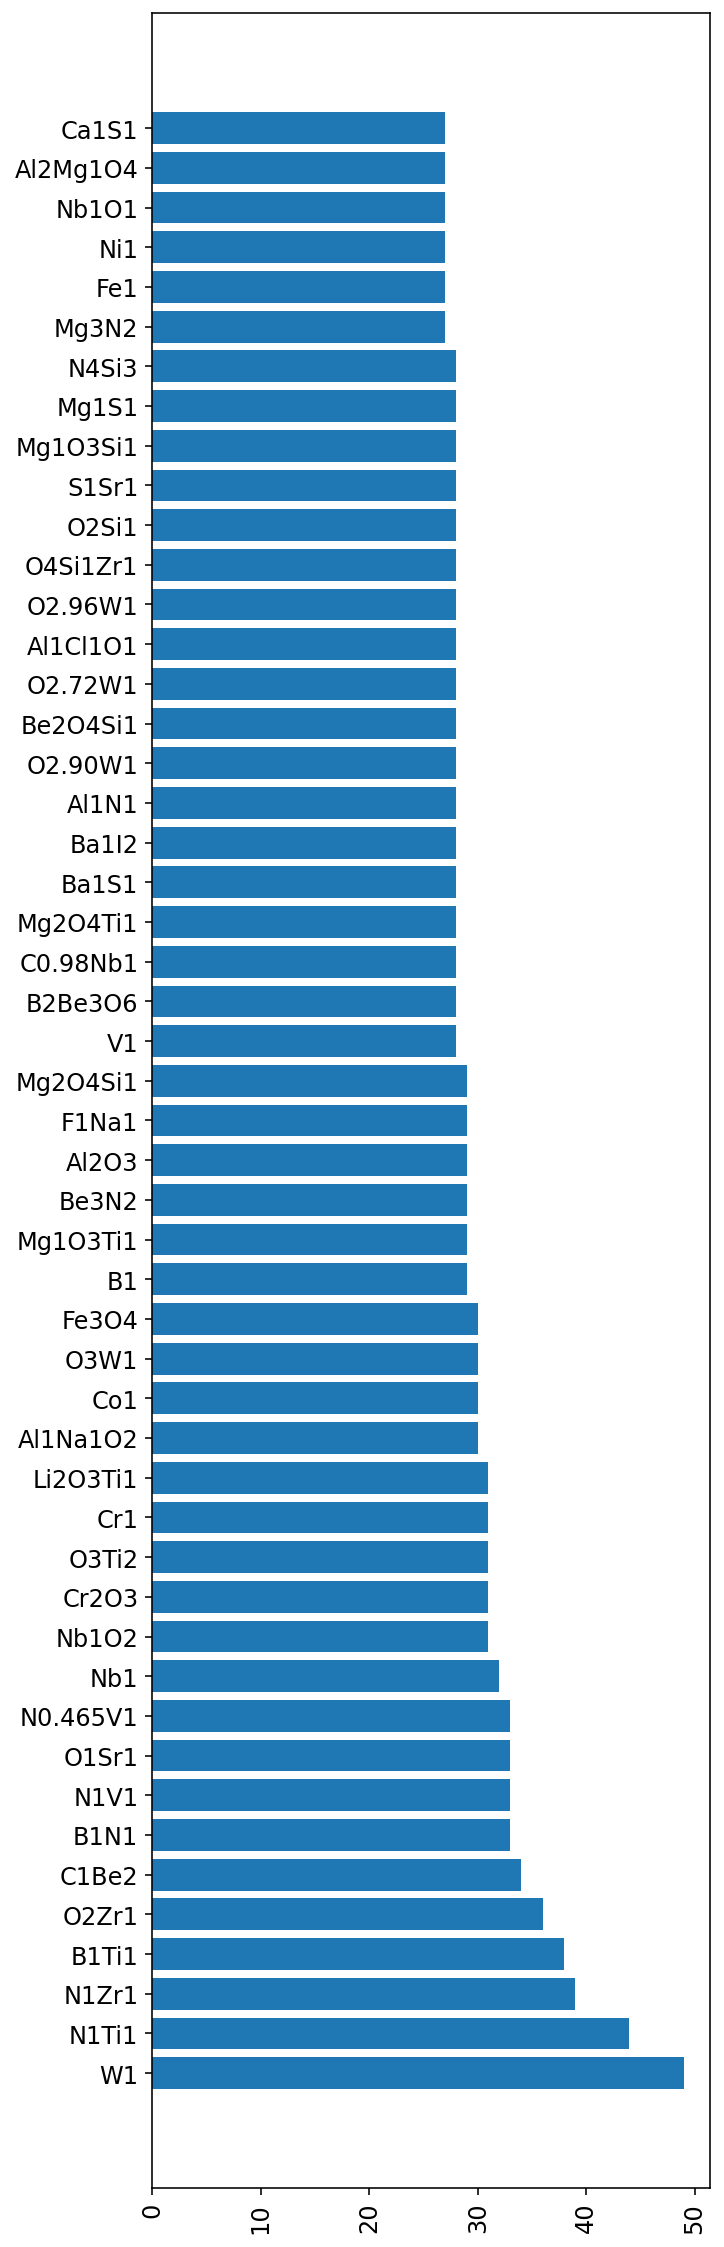

In [20]:
f_entries = df['formula'].value_counts()[:50]

fig, ax = plt.subplots(1,1, figsize=(5,20))
ax.barh(f_entries.index, f_entries.values)
ax.tick_params(axis='x', rotation=90);

In [21]:
df['formula'].unique()[:10]

array(['B2O3', 'Be1I2', 'Be1F3Li1', 'Al1Cl4K1', 'Al2Be1O4', 'B2H4O4',
       'B2Mg1', 'Be1F2', 'B1H4Na1', 'Br2Ca1'], dtype=object)

Creating train/val/test manually 

In [22]:
unique_entries = df['formula'].unique()

In [23]:
# Set size for train/val/test set 
train_set = 0.7
val_set = 0.2
test_set = 1 - train_set - val_set 

In [24]:
num_entries_train = int( train_set * len(unique_entries) )
num_entries_val = int( val_set * len(unique_entries) )
num_entries_test = int( test_set * len(unique_entries) )

In [25]:
print(num_entries_train, num_entries_val, num_entries_test)

170 48 24


In [26]:
# Train formula 
train_formulae = np.random.choice(unique_entries, num_entries_train, replace=False)
unique_entries_minus_train = [i for i in unique_entries if i not in train_formulae]

# Val formula 
val_formulae = np.random.choice(unique_entries_minus_train, num_entries_val, replace=False)
unique_entries_minus_train_val = [i for i in unique_entries_minus_train if i not in val_formulae]

# Test formula 
test_formulae = unique_entries_minus_train_val.copy()

In [27]:
print(len(train_formulae), len(val_formulae), len(test_formulae))

170 48 26


In [28]:
train_points = df.loc[ df['formula'].isin(train_formulae) ]
val_points = df.loc[ df['formula'].isin(val_formulae) ]
test_points = df.loc[ df['formula'].isin(test_formulae) ]

In [29]:
print(train_points.shape, val_points.shape, test_points.shape)

(3131, 3) (944, 3) (489, 3)


In [30]:
# Quick sanity check of the method 
train_set = set(train_points['formula'].unique())
val_set = set(val_points['formula'].unique())
test_set = set(test_points['formula'].unique())

# Check for intersection with val and test
print(len(train_set.intersection(val_set)), len(train_set.intersection(test_set)))

0 0


# Model fitting 

## Featurization

Composition-based feature vector (CBFV) is used to describe each mateiral entry (eg: Cr<sub>2</sub>O<sub>3</sub>) with set of elemental and composition based numbers. 

In [31]:
# Import the package and the generate_features function
from cbfv.composition import generate_features

In [32]:
rename_columns = {'Cp':'target'}
train_points['Type'] = 'Train'
val_points['Type'] = 'Val'
test_points['Type'] = 'Test'
total_data = pd.concat([train_points, val_points, test_points], ignore_index=True);

total_data = total_data.rename(columns=rename_columns)

/Users/pghaneka/miniconda3/envs/torch_38/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/pghaneka/miniconda3/envs/torch_38/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pghaneka/miniconda3/envs/torch_38/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a

In [33]:
total_data.sample(5)

,formula,T,target,Type
3833,I1K1,1400.0,74.601,Val
4215,Cr2O3,298.0,120.366,Test
1290,I2Mo1,1000.0,91.458,Train
1578,I2Zr1,700.0,97.445,Train
2379,Na2O5Si2,1700.0,292.880,Train


In [34]:
train_df = total_data.loc[ total_data['Type'] == 'Train' ].drop(columns=['Type']).reset_index(drop=True)
val_df = total_data.loc[ total_data['Type'] == 'Val' ].drop(columns=['Type']).reset_index(drop=True)
test_df = total_data.loc[ total_data['Type'] == 'Test' ].drop(columns=['Type']).reset_index(drop=True)

### Sub-sampling 

Only some points from the original training data `train_df` are used to ensure the analysis is tractable

In [35]:
train_df.shape

(3131, 3)

In [36]:
train_df = train_df.sample(n=1000, random_state=42)
train_df.shape

(1000, 3)

In [37]:
# Generate features 
X_unscaled_train, y_train, formulae_entry_train, skipped_entry = generate_features(train_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_unscaled_val, y_val, formulae_entry_val, skipped_entry = generate_features(val_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_unscaled_test, y_test, formulae_entry_test, skipped_entry = generate_features(test_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Assigning Features...:   0%|          | 0/1000 [00:00<?, ?it/s]

	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1000/1000 [00:00<00:00, 13526.13it/s]

	Creating Pandas Objects...



Assigning Features...:   0%|          | 0/944 [00:00<?, ?it/s]

	Featurizing Compositions...


Assigning Features...: 100%|██████████| 944/944 [00:00<00:00, 14855.23it/s]


	Creating Pandas Objects...


Assigning Features...: 100%|██████████| 489/489 [00:00<00:00, 12626.83it/s]


	Featurizing Compositions...
	Creating Pandas Objects...


In [38]:
X_unscaled_train.head(5)

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,range_Melting_point_(K),range_Boiling_Point_(K),range_Density_(g/mL),range_specific_heat_(J/g_K)_,range_heat_of_fusion_(kJ/mol)_,range_heat_of_vaporization_(kJ/mol)_,range_thermal_conductivity_(W/(m_K))_,range_heat_atomization(kJ/mol),range_Cohesive_energy,T
0,64.0,139.938350,10.5,50.0,23.25,1.0,2.75,0.0,289.25,4.75,...,2009873.29,5.748006e+06,26.002708,0.112225,252.450947,88384.346755,4759.155119,41820.25,4.410000,1100.0
1,58.0,119.979000,10.0,40.0,18.00,1.0,2.00,0.0,231.00,4.00,...,505663.21,1.328602e+06,8.381025,0.018225,36.496702,28866.010000,1597.241190,4830.25,0.511225,1100.0
2,27.0,58.691000,6.0,17.0,10.00,1.0,0.00,1.0,115.00,3.00,...,43890.25,1.277526e+05,1.210000,0.062500,301.890625,1179.922500,6.502500,2652.25,0.230400,3400.0
3,36.0,72.144000,7.0,18.0,9.00,1.0,1.00,0.0,95.00,1.00,...,131841.61,2.700361e+05,0.067600,0.001600,11.636627,5148.062500,9973.118090,2550.25,0.255025,2900.0
4,80.0,162.954986,19.0,120.0,56.00,0.0,8.00,0.0,659.00,8.00,...,16129.00,5.659641e+04,0.826963,0.018225,0.021993,21.791158,0.010922,6241.00,0.555025,1300.0


In [39]:
formulae_entry_train.head(5)

0    Mo1O2.750
1        Fe1S2
2        B1Ti1
3        Ca1S1
4         N5P3
Name: formula, dtype: object

In [40]:
X_unscaled_train.shape

(1000, 177)

## Feature scaling

In [41]:
X_unscaled_train.columns

Index(['sum_Atomic_Number', 'sum_Atomic_Weight', 'sum_Period', 'sum_group',
       'sum_families', 'sum_Metal', 'sum_Nonmetal', 'sum_Metalliod',
       'sum_Mendeleev_Number', 'sum_l_quantum_number',
       ...
       'range_Melting_point_(K)', 'range_Boiling_Point_(K)',
       'range_Density_(g/mL)', 'range_specific_heat_(J/g_K)_',
       'range_heat_of_fusion_(kJ/mol)_',
       'range_heat_of_vaporization_(kJ/mol)_',
       'range_thermal_conductivity_(W/(m_K))_',
       'range_heat_atomization(kJ/mol)', 'range_Cohesive_energy', 'T'],
      dtype='object', length=177)

In [42]:
X_unscaled_train.describe().round(2)

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,range_Melting_point_(K),range_Boiling_Point_(K),range_Density_(g/mL),range_specific_heat_(J/g_K)_,range_heat_of_fusion_(kJ/mol)_,range_heat_of_vaporization_(kJ/mol)_,range_thermal_conductivity_(W/(m_K))_,range_heat_atomization(kJ/mol),range_Cohesive_energy,T
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,66.57,147.21,11.28,46.27,23.19,1.28,2.64,0.08,292.01,3.73,...,579042.62,1803422.99,8.45,3.34,181.31,28201.58,3305.55,14959.38,1.70,1195.38
std,48.94,116.53,6.33,36.29,16.68,0.76,2.32,0.31,210.15,2.59,...,750702.41,2017584.79,17.52,10.61,413.13,36421.94,4474.33,22191.74,2.45,760.90
min,4.00,7.95,2.00,1.00,1.00,0.00,0.00,0.00,3.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,31.00,65.12,6.00,18.00,10.00,1.00,1.00,0.00,126.00,2.00,...,20619.03,199191.78,0.23,0.01,1.88,1451.91,119.61,729.00,0.09,600.00
50%,55.00,118.00,10.00,36.00,20.00,1.00,2.00,0.00,247.00,3.00,...,222030.88,1169819.78,1.25,0.05,20.92,18260.29,1607.65,5312.67,0.63,1054.00
75%,86.00,182.15,15.00,72.00,36.00,2.00,4.00,0.00,442.00,5.00,...,882096.64,3010225.00,9.33,0.12,171.31,40317.25,4968.28,18080.67,2.08,1600.00
max,278.00,685.60,41.00,256.00,113.00,4.00,15.00,2.00,1418.00,19.00,...,3291321.64,8535162.25,93.11,44.12,2391.45,168342.03,40198.47,95733.56,10.59,4600.00


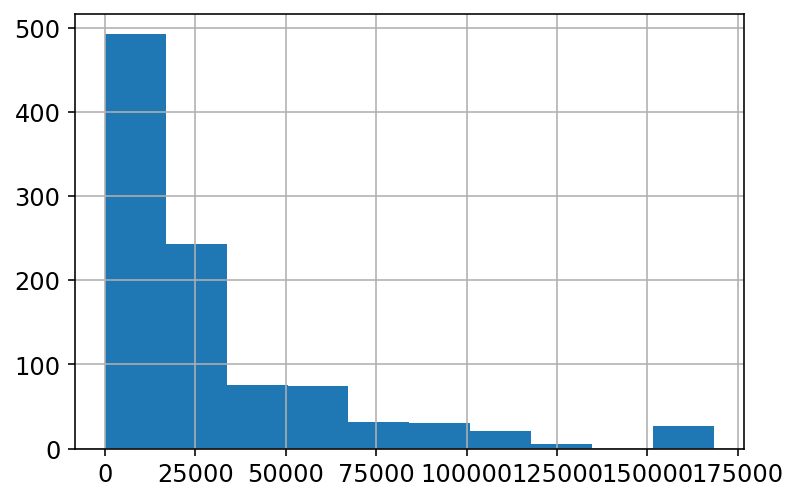

In [43]:
X_unscaled_train['range_heat_of_vaporization_(kJ/mol)_'].hist();

In [44]:
from sklearn.preprocessing import StandardScaler, normalize

In [45]:
stdscaler = StandardScaler()
X_train = stdscaler.fit_transform(X_unscaled_train)
X_val = stdscaler.transform(X_unscaled_val)
X_test = stdscaler.transform(X_unscaled_test)

In [46]:
pd.DataFrame(X_train, columns=X_unscaled_train.columns).describe().round(2)

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,range_Melting_point_(K),range_Boiling_Point_(K),range_Density_(g/mL),range_specific_heat_(J/g_K)_,range_heat_of_fusion_(kJ/mol)_,range_heat_of_vaporization_(kJ/mol)_,range_thermal_conductivity_(W/(m_K))_,range_heat_atomization(kJ/mol),range_Cohesive_energy,T
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.28,-1.20,-1.47,-1.25,-1.33,-1.68,-1.14,-0.27,-1.38,-1.44,...,-0.77,-0.89,-0.48,-0.31,-0.44,-0.77,-0.74,-0.67,-0.69,-1.57
25%,-0.73,-0.70,-0.83,-0.78,-0.79,-0.36,-0.71,-0.27,-0.79,-0.67,...,-0.74,-0.80,-0.47,-0.31,-0.43,-0.73,-0.71,-0.64,-0.66,-0.78
50%,-0.24,-0.25,-0.20,-0.28,-0.19,-0.36,-0.27,-0.27,-0.21,-0.28,...,-0.48,-0.31,-0.41,-0.31,-0.39,-0.27,-0.38,-0.43,-0.43,-0.19
75%,0.40,0.30,0.59,0.71,0.77,0.96,0.59,-0.27,0.71,0.49,...,0.40,0.60,0.05,-0.30,-0.02,0.33,0.37,0.14,0.15,0.53
max,4.32,4.62,4.69,5.78,5.39,3.59,5.34,6.18,5.36,5.89,...,3.61,3.34,4.83,3.84,5.35,3.85,8.25,3.64,3.62,4.48


<AxesSubplot:>

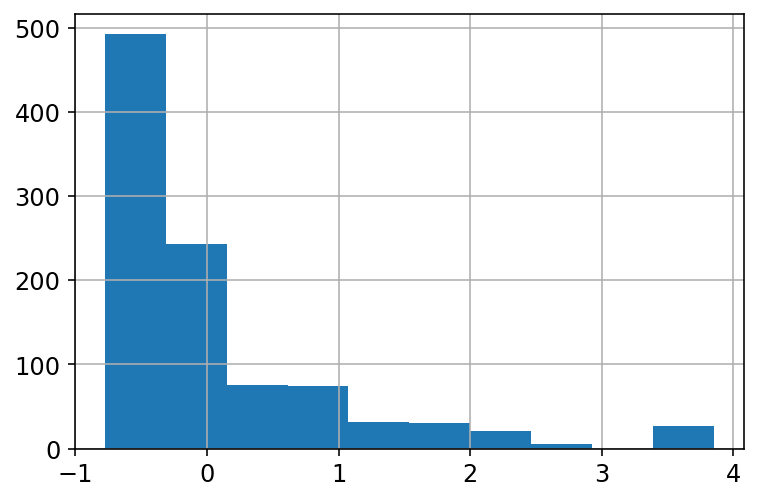

In [47]:
pd.DataFrame(X_train, columns=X_unscaled_train.columns)['range_heat_of_vaporization_(kJ/mol)_'].hist()

In [48]:
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [49]:
pd.DataFrame(X_train, columns=X_unscaled_train.columns).describe().round(2)

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,range_Melting_point_(K),range_Boiling_Point_(K),range_Density_(g/mL),range_specific_heat_(J/g_K)_,range_heat_of_fusion_(kJ/mol)_,range_heat_of_vaporization_(kJ/mol)_,range_thermal_conductivity_(W/(m_K))_,range_heat_atomization(kJ/mol),range_Cohesive_energy,T
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,-0.01,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.01,-0.00,0.00,...,0.00,0.01,-0.00,-0.01,-0.00,0.01,0.00,-0.00,-0.00,0.00
std,0.07,0.07,0.07,0.07,0.07,0.08,0.07,0.07,0.07,0.08,...,0.08,0.08,0.07,0.07,0.07,0.08,0.09,0.08,0.08,0.09
min,-0.12,-0.11,-0.13,-0.11,-0.11,-0.12,-0.11,-0.04,-0.12,-0.13,...,-0.08,-0.10,-0.06,-0.05,-0.05,-0.08,-0.12,-0.09,-0.09,-0.19
25%,-0.06,-0.06,-0.06,-0.06,-0.06,-0.04,-0.06,-0.03,-0.06,-0.05,...,-0.05,-0.05,-0.03,-0.03,-0.04,-0.05,-0.05,-0.05,-0.05,-0.06
50%,-0.02,-0.03,-0.02,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,...,-0.03,-0.03,-0.03,-0.02,-0.03,-0.02,-0.03,-0.04,-0.04,-0.02
75%,0.03,0.02,0.06,0.06,0.06,0.06,0.05,-0.02,0.07,0.05,...,0.04,0.04,0.01,-0.02,-0.00,0.02,0.03,0.02,0.01,0.05
max,0.25,0.26,0.19,0.20,0.19,0.25,0.20,0.40,0.19,0.24,...,0.22,0.23,0.29,0.32,0.43,0.26,0.58,0.26,0.24,0.38


<AxesSubplot:>

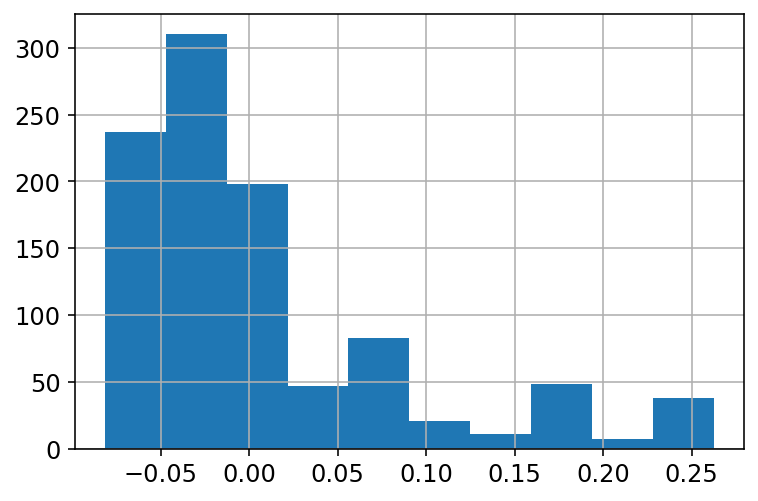

In [50]:
pd.DataFrame(X_train, columns=X_unscaled_train.columns)['range_heat_of_vaporization_(kJ/mol)_'].hist()

## Model fitting 

In [51]:
from time import time 

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [52]:
model = RandomForestRegressor(random_state=42)

In [53]:
%%time
model.fit(X_train, y_train)

CPU times: user 5.51 s, sys: 31.7 ms, total: 5.54 s
Wall time: 5.57 s


RandomForestRegressor(random_state=42)

In [54]:
def display_performance(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print('R2: {0:0.2f}\n'
          'MAE: {1:0.2f}\n'
          'RMSE: {2:0.2f}'.format(r2, mae, rmse))
    return(r2, mae, rmse)

In [55]:
y_pred = model.predict(X_val)
display_performance(y_val,y_pred);

R2: 0.81
MAE: 14.03
RMSE: 20.48


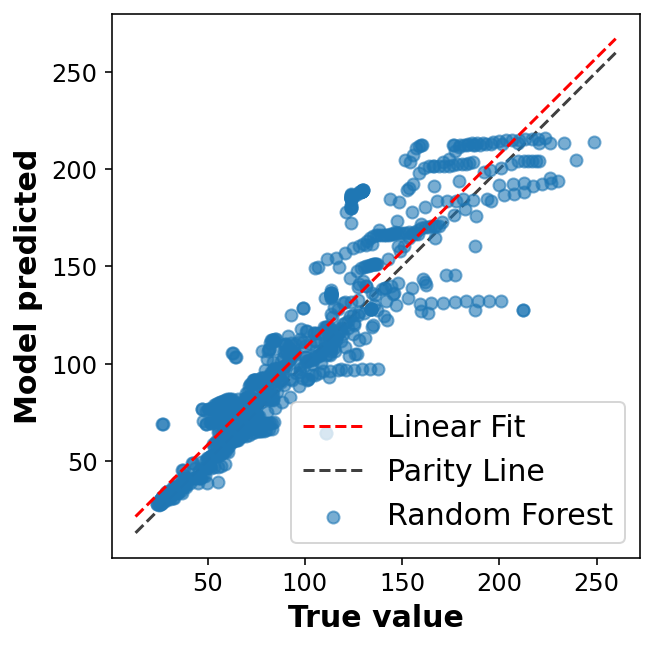

In [56]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(y_val, y_pred, alpha=0.6, label='Random Forest')

lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
# Linear fit
reg = np.polyfit(y_val, y_pred, deg=1)
ax.plot(lims, reg[0] * np.array(lims) + reg[1], 'r--', linewidth=1.5, label='Linear Fit')
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Parity Line')
ax.set_aspect('equal')
        
ax.set_xlabel('True value')
ax.set_ylabel('Model predicted')
ax.legend(loc='best')

## Feature Importance

In [57]:
feature_name = [i for i in X_unscaled_train.columns]

In [58]:
len(feature_name)

177

In [59]:
X_train.shape

(1000, 177)

In [60]:
len(model.estimators_)

100

In [61]:
mean_feature_importance = model.feature_importances_
std_feature_importance = np.std([ tree.feature_importances_ for tree in model.estimators_ ], axis=0)

In [62]:
feat_imp_df = pd.DataFrame({'name':feature_name, 'mean_imp':mean_feature_importance, 'std_dev':std_feature_importance})

In [63]:
feat_imp_df_top = feat_imp_df.sort_values('mean_imp', ascending=False)[:20]

In [64]:
feat_imp_df_top[:5]

,name,mean_imp,std_dev
24,sum_valence_s,0.383415,0.273328
12,sum_Covalent_Radius,0.205463,0.220244
17,sum_MB_electonegativity,0.098704,0.212963
31,sum_Number_of_unfilled_f_valence_electrons,0.076559,0.028590
176,T,0.049666,0.008509


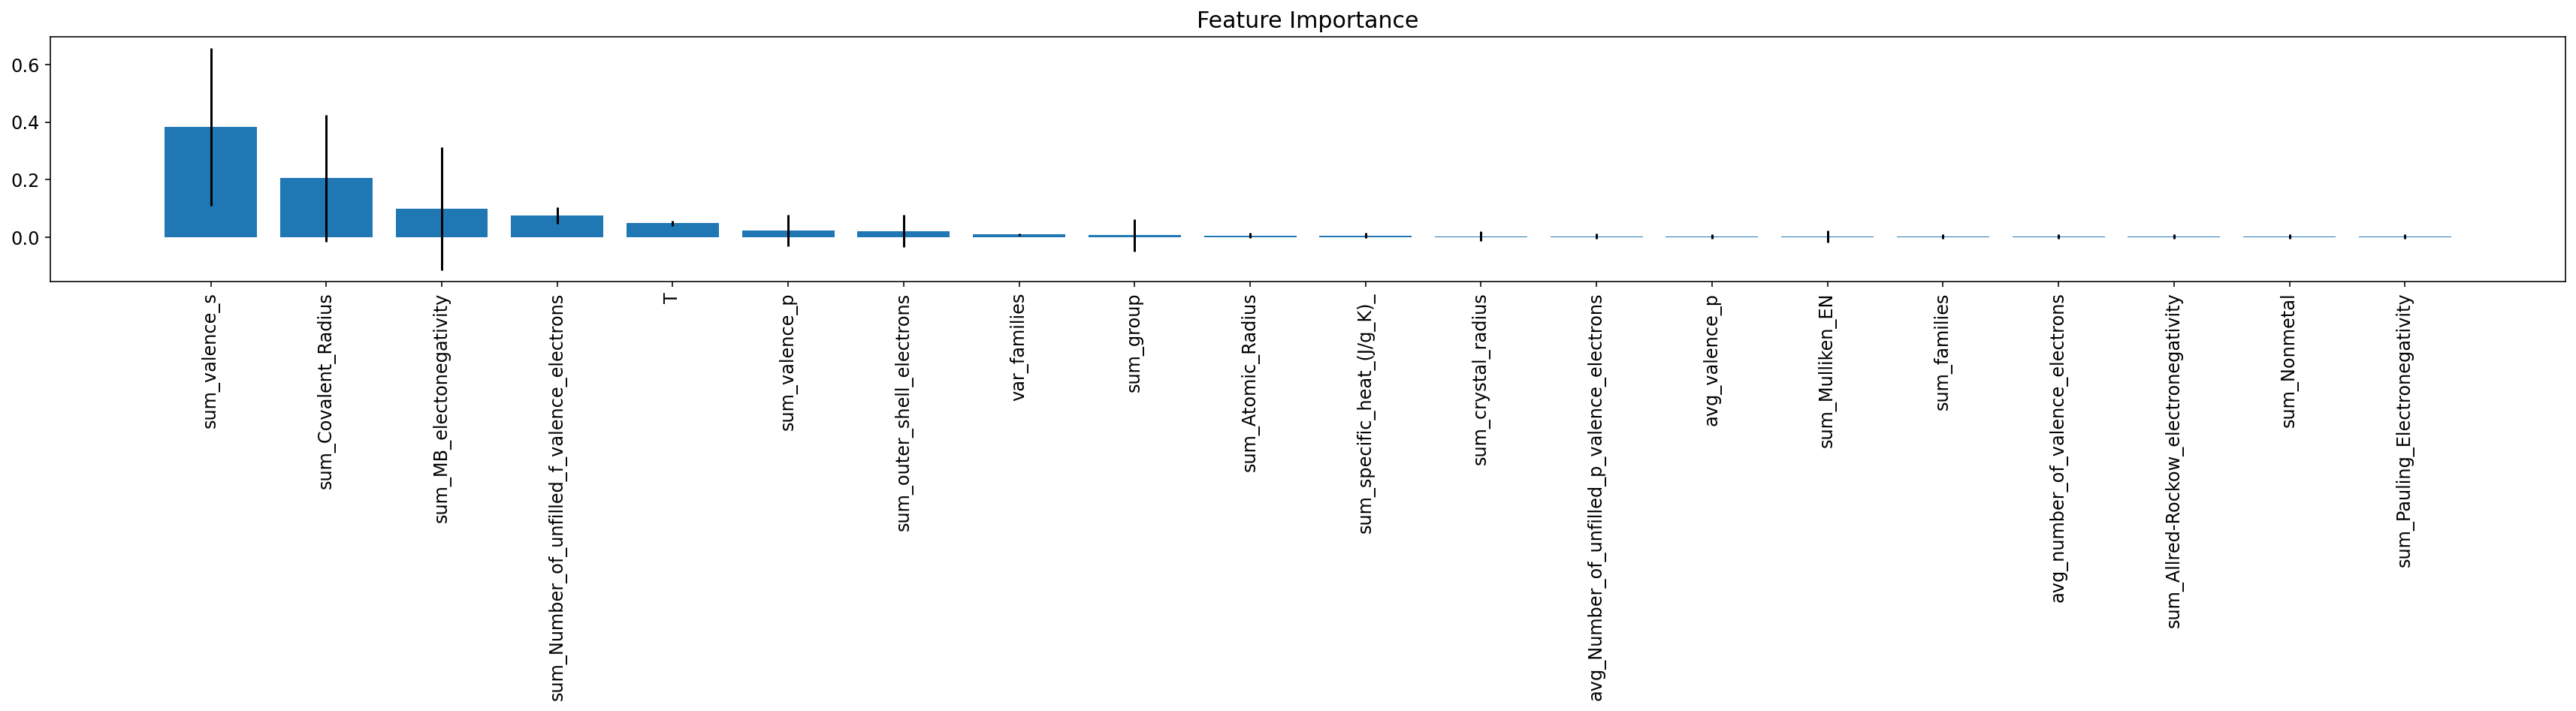

In [65]:
fig, ax = plt.subplots(1,1, figsize=(30,3))
ax.bar(feat_imp_df_top['name'], feat_imp_df_top['mean_imp'], yerr=feat_imp_df_top['std_dev'])
ax.tick_params(axis='x', rotation=90)
ax.set_title('Feature Importance');

In [66]:
top_feature_list = feat_imp_df.loc[ feat_imp_df['mean_imp'] > 0.001 ]['name']

In [67]:
len(top_feature_list)

40

In [68]:
X_train_df = pd.DataFrame(X_train, columns=feature_name)
X_val_df = pd.DataFrame(X_val, columns=feature_name)

X_train_short = X_train_df[list(top_feature_list)]
X_val_short = X_val_df[list(top_feature_list)]

In [69]:
print(X_train_short.shape, X_train.shape)

(1000, 40) (1000, 177)


### Refit a new model on small feature set 

In [70]:
model_small = RandomForestRegressor(random_state=42)

In [71]:
%%time
model_small.fit(X_train_short, y_train)

CPU times: user 1.41 s, sys: 13.9 ms, total: 1.43 s
Wall time: 1.44 s


RandomForestRegressor(random_state=42)

In [72]:
y_pred = model_small.predict(X_val_short)
display_performance(y_val, y_pred);

R2: 0.81
MAE: 13.87
RMSE: 20.40


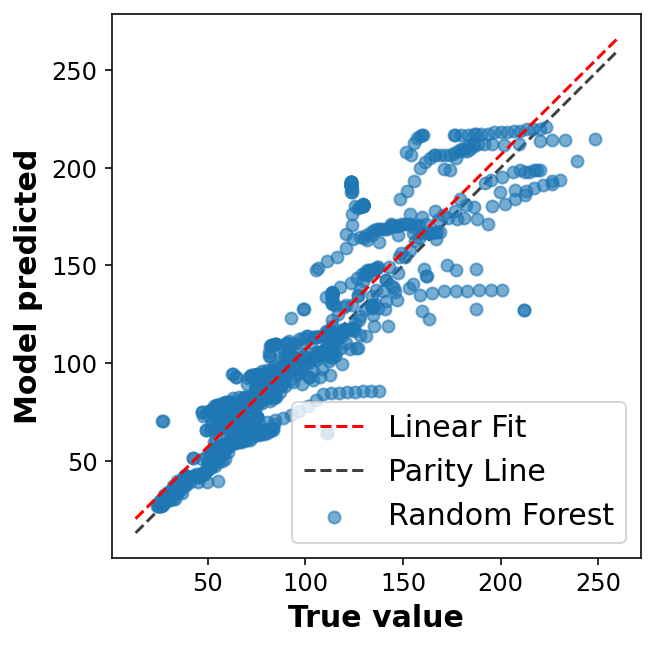

In [73]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(y_val, y_pred, alpha=0.6, label='Random Forest')

lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
# Linear fit
reg = np.polyfit(y_val, y_pred, deg=1)
ax.plot(lims, reg[0] * np.array(lims) + reg[1], 'r--', linewidth=1.5, label='Linear Fit')
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Parity Line')
ax.set_aspect('equal')
        
ax.set_xlabel('True value')
ax.set_ylabel('Model predicted')
ax.legend(loc='best')

## Cross-validation

Combine train and validation set to generate one train - test set for cross-validation

In [74]:
# Train stack 
X_y_train = np.c_[X_train_short, y_train]
X_y_train.shape

(1000, 41)

In [75]:
np.unique(X_y_train[:,-1] - y_train)

array([0.])

In [76]:
# Validation stack
X_y_val = np.c_[X_val_short, y_val]

In [77]:
X_Y_TRAIN = np.vstack((X_y_train, X_y_val))

In [78]:
X_TRAIN = X_Y_TRAIN[:,0:-1].copy()
Y_TRAIN = X_Y_TRAIN[:,-1].copy()

print(X_TRAIN.shape, Y_TRAIN.shape)

(1944, 40) (1944,)


In [79]:
from sklearn.model_selection import cross_validate

def display_score(scores, metric):
    score_key = 'test_{}'.format(metric)
    print(metric)
    print('Mean: {}'.format(scores[score_key].mean()))
    print('Std dev: {}'.format(scores[score_key].std()))

In [80]:
%%time
_scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']
forest_scores = cross_validate(model, X_TRAIN, Y_TRAIN, 
                              scoring = _scoring, cv=5)

CPU times: user 11.1 s, sys: 66 ms, total: 11.1 s
Wall time: 11.2 s


In [81]:
display_score(forest_scores, _scoring[0])

neg_root_mean_squared_error
Mean: -15.22268277329878
Std dev: 3.677396464443359


In [82]:
display_score(forest_scores, _scoring[1])

neg_mean_absolute_error
Mean: -9.559763633911203
Std dev: 2.786793874037375


## Hyperparameter Optimization

In [83]:
import joblib
from sklearn.model_selection import RandomizedSearchCV

In [84]:
random_forest_base_model = RandomForestRegressor(random_state=42)

param_grid = {
    'bootstrap':[True],
    'min_samples_leaf':[5,10,100,200,500],
    'min_samples_split':[5,10,100,200,500],
    'n_estimators':[100,200,400,500],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[5,10,15,20]
}

In [85]:
CV_rf = RandomizedSearchCV(estimator=random_forest_base_model, 
                           n_iter=50, 
                           param_distributions=param_grid, 
                           scoring='neg_root_mean_squared_error',
                           cv = 5, verbose = 1, n_jobs=-1, refit=True)

In [86]:
%%time
with joblib.parallel_backend('multiprocessing'):
    CV_rf.fit(X_TRAIN, Y_TRAIN)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 646 ms, sys: 183 ms, total: 829 ms
Wall time: 1min 5s


In [87]:
print(CV_rf.best_params_, CV_rf.best_score_)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True} -19.161578679126375


In [88]:
pd.DataFrame(CV_rf.cv_results_).sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,2.390702,0.061919,0.014793,0.000683,100,10,10,auto,20,True,"{'n_estimators': 100, 'min_samples_split': 10,...",-19.636059,-20.949326,-16.321387,-18.878979,-20.022143,-19.161579,1.568968,1
20,1.299131,0.010285,0.033008,0.003166,200,10,10,sqrt,10,True,"{'n_estimators': 200, 'min_samples_split': 10,...",-21.980440,-23.012936,-18.847124,-19.781677,-17.760789,-20.276593,1.949783,2
22,10.616245,0.066480,0.084979,0.025942,500,5,10,auto,5,True,"{'n_estimators': 500, 'min_samples_split': 5, ...",-21.048335,-23.039862,-18.059296,-18.935399,-20.566808,-20.329940,1.733000,3
40,3.364752,0.126191,0.089052,0.004354,500,10,10,sqrt,15,True,"{'n_estimators': 500, 'min_samples_split': 10,...",-22.245647,-23.261791,-18.796893,-20.179776,-17.747398,-20.446301,2.061082,4
2,0.448634,0.006245,0.015180,0.001035,100,5,10,log2,20,True,"{'n_estimators': 100, 'min_samples_split': 5, ...",-22.658766,-23.491199,-19.473837,-20.457559,-17.931118,-20.802496,2.039804,5


In [89]:
best_model = CV_rf.best_estimator_

In [90]:
best_model

RandomForestRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=10,
                      random_state=42)